In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Early stopping at epoch 239
Last Hidden State Weights:
[[-1.27591029e-01 -2.58992501e-02 -2.42706478e-01 -4.69207735e-04
  -2.33324431e-02  5.09447651e-03 -1.51473865e-01 -1.57666579e-01
  -1.35763928e-01 -2.28524834e-01 -1.15196526e-01  2.34980196e-01
  -1.97484016e-01  9.98256058e-02 -1.91982448e-01 -6.33308217e-02
   5.68711720e-02 -2.28385568e-01  4.61494848e-02 -1.19915888e-01
  -1.01082340e-01 -2.10201219e-01 -1.89453125e-01  5.94722182e-02
   2.59510785e-01  1.75440356e-01 -1.11125648e-01 -2.19523922e-01
  -6.85581863e-02 -3.19008917e-01 -2.34273657e-01 -7.97121078e-02]
 [-8.19341689e-02 -4.69859242e-02 -2.27785110e-01 -3.00410204e-02
   5.58704080e-04  1.42537756e-02 -1.39018983e-01 -1.47177294e-01
  -1.07949033e-01 -1.93260908e-01 -1.26180872e-01  2.11587071e-01
  -2.39666298e-01  6.58455789e-02 -1.82631060e-01 -3.87162603e-02
   9.09544826e-02 -1.88533708e-01  5.77739999e-02 -6.38863444e-02
  -7.64514282e-02 -1.59653589e-01 -2.42551908e-01  3.17077115e-02
   2.45875403e-01  1

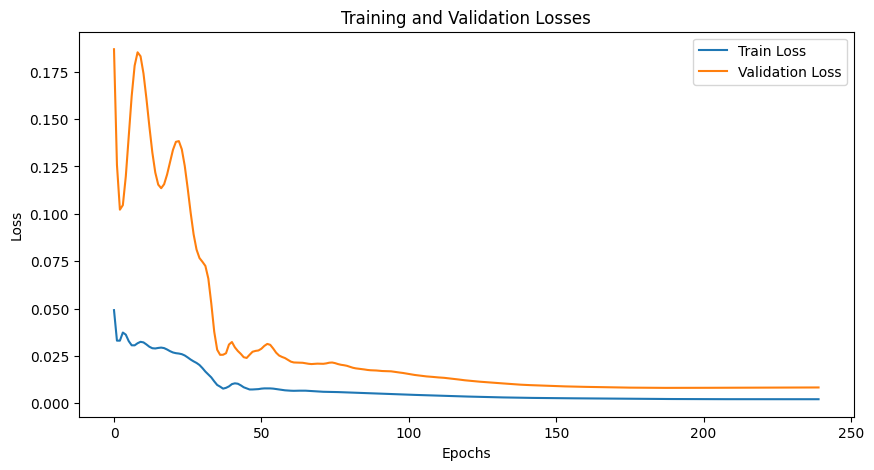

Last Hidden State Weights:
[[-0.21251921]
 [ 0.1690965 ]
 [-0.05608081]
 [ 0.15068859]
 [-0.12244605]
 [-0.06360408]
 [-0.035087  ]
 [-0.09677663]
 [-0.09870764]
 [-0.11390401]
 [ 0.03852987]
 [ 0.14397955]
 [ 0.24656254]
 [ 0.16235927]
 [ 0.02569324]
 [-0.12515341]
 [-0.13402249]
 [-0.23874143]
 [-0.02404622]
 [-0.2635068 ]
 [-0.11114404]
 [-0.16398409]
 [ 0.20133267]
 [ 0.12069482]
 [ 0.08499179]
 [-0.09734714]
 [-0.21506   ]
 [-0.20735396]
 [-0.20319533]
 [ 0.05996964]
 [-0.25029582]
 [-0.20922123]]


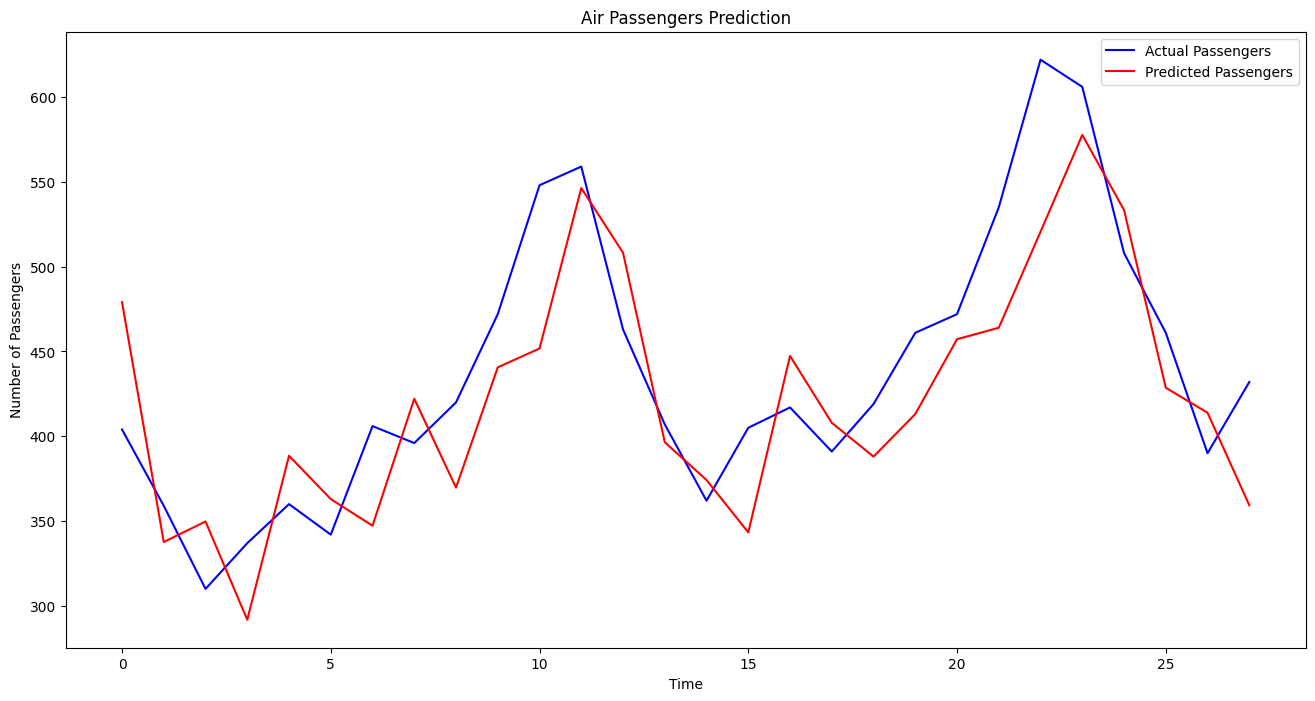

In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from urllib.request import urlopen
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

class AirPassengersRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=4):
        super(AirPassengersRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN Layers
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Ensure correct tensor dimensions
        if x.dim() == 4:
            x = x.squeeze(3)  # Remove last dimension if it exists
        if x.dim() == 2:
            x = x.unsqueeze(1)  # Add sequence dimension if missing

        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,
                         dtype=x.dtype, device=x.device)

        # Forward propagate RNN
        out, hidden = self.rnn(x, h0)

        # Decode the output of the last time step
        out = self.fc(out[:, -1, :])

        # Return the output and the last hidden state
        return out, hidden

def load_data(url):
    """
    Load data from URL with error handling
    """
    try:
        # Use urlopen to handle potential network issues
        with urlopen(url) as response:
            data = pd.read_csv(response)

        # Validate data
        if 'Passengers' not in data.columns:
            raise ValueError("'Passengers' column not found in the dataset")

        return data
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def prepare_data(data, sequence_length=6):
    """
    Prepare data for RNN training
    """
    if data is None:
        raise ValueError("No data to prepare")

    # Extract passengers column
    df = data[['Passengers']]

    # Scale data
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = scaler.fit_transform(df.values)

    # Create sequences
    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled[i:i+sequence_length].flatten())
        y.append(df_scaled[i+sequence_length])

    # Convert to numpy arrays and then to torch tensors
    X = torch.FloatTensor(np.array(X).reshape(-1, sequence_length, 1))
    y = torch.FloatTensor(np.array(y))

    return X, y, scaler

def train_model(X_train, y_train, X_test, y_test, patience=50):
    """
    Train RNN model with early stopping
    """
    # Initialize model, loss, and optimizer
    model = AirPassengersRNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Tracking variables for early stopping
    best_val_loss = float('inf')
    epochs_no_improve = 0
    train_losses, val_losses = [], []

    # Training loop with early stopping
    for epoch in range(1000):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        outputs, _ = model(X_train)
        loss = criterion(outputs, y_train)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs, _ = model(X_test)
            val_loss = criterion(val_outputs, y_test)

        # Record losses
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        # Stop if no improvement
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    return model, train_losses, val_losses

def plot_losses(train_losses, val_losses):
    """
    Plot training and validation losses
    """
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_predictions(y_test, predictions, scaler):
    """
    Plot actual vs predicted values
    """
    # Inverse transform
    predictions_orig = scaler.inverse_transform(predictions.detach().numpy().reshape(-1, 1))
    y_test_orig = scaler.inverse_transform(y_test.numpy().reshape(-1, 1))

    plt.figure(figsize=(16,8))
    plt.plot(y_test_orig, label='Actual Passengers', color='blue')
    plt.plot(predictions_orig, label='Predicted Passengers', color='red')
    plt.title('Air Passengers Prediction')
    plt.xlabel('Time')
    plt.ylabel('Number of Passengers')
    plt.legend()
    plt.show()

def main():
    # URL for Air Passengers dataset
    url = 'https://raw.githubusercontent.com/Manishms18/Air-Passengers-Time-Series-Analysis/master/Data/AirPassengers.csv'

    # Load and prepare data
    try:
        # Load data
        data = load_data(url)

        # Prepare data
        X, y, scaler = prepare_data(data)

        # Split data into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Train the model
        model, train_losses, val_losses = train_model(X_train, y_train, X_test, y_test)
        _, last_hidden_state = model(X_test)
        last_hidden_weights = last_hidden_state[0].detach().cpu().numpy()  # Extract the weights from the first layer

    # Print the last hidden state weights
        print("Last Hidden State Weights:")
        print(last_hidden_weights)

        # Plot losses
        plot_losses(train_losses, val_losses)

        # Make predictions
        model.eval()
        with torch.no_grad():
            predictions, last_hidden_state = model(X_test)

        # Access the last hidden state weights
        last_hidden_weights = model.rnn.weight_ih_l0.detach().cpu().numpy()
        print("Last Hidden State Weights:")
        print(last_hidden_weights)

        # Plot predictions
        plot_predictions(y_test, predictions, scaler)

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()